# 1. Imports and Setup

Clustering-ի նկարի չափերի փոքրացման հետ կապված էլ կարող եք կարդալ այստեղ - https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf Բաժին 9.1.1

In [ ]:
!pip install Pillow numpy scikit-learn tqdm

In [24]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm

In [25]:
RESIZE_IMAGE = False
WIDTH = 1_000

# 2. Load and Display the Input Image

Image size: (478, 640) | # pixels: 305920


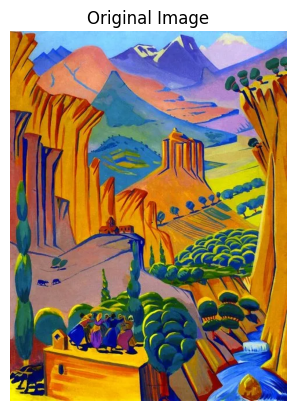

Num of unique colors: 175,562


In [47]:
# input_image_path = "sevan.png"
# input_image_path = "Armenia.jpg" # may work poorly with png images
# input_image_path = "Aivazovsky.jpg" # may work poorly with png images
input_image_path = "Saryan.jpg"


image = Image.open(input_image_path)

print(f"Image size: {image.size} | # pixels: {image.size[0] * image.size[1]}")

# Display the original image
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

if RESIZE_IMAGE:
    # resize the image but keep the aspect ratio
    width, height = image.size
    aspect_ratio = width / height
    new_width = 1000
    new_height = int(new_width / aspect_ratio)

    image = image.resize((new_width, new_height))

    # Display the resized image
    plt.imshow(image)
    plt.title("Resized Image")
    plt.axis('off')
    plt.show()

    print(f"Resized image size: {image.size} | # pixels: {image.size[0] * image.size[1]}")


if input_image_path.endswith(".jpg"):
    print(f"Num of unique colors: {len(set(image.getdata())):,}")

# 3. Convert Image to NumPy and Flatten

In [48]:
# Convert PIL image to NumPy array
image_np = np.array(image)

if input_image_path.endswith(".png"):
    height, width = image_np.shape
    num_channels = 3
else:
    height, width, num_channels = image_np.shape
print(f"Original image shape: {image_np.shape}")

# Flatten the image to (num_pixels, num_channels)
pixels = image_np.reshape(-1, num_channels).astype(np.float32)

# Scale pixels from [0, 255] to [0, 1]
pixels /= 255.0
print("Flattened pixels shape:", pixels.shape)
print("Pixel sample:", pixels[0])  # just to see an example pixel


Original image shape: (640, 478, 3)
Flattened pixels shape: (305920, 3)
Pixel sample: [0.78431374 0.63529414 0.4       ]


In [49]:
if input_image_path.endswith(".png"):
    print(f"Num of unique colors: {len(set(map(tuple, pixels)))}")

# 4. Evaluate Different Numbers of Clusters

In [50]:
num_clusters_list = [2, 4, 6, 8, 10, 12]
inertias = []
silhouette_scores = []
centroids = []

print(len(pixels))

for n_clusters in tqdm(num_clusters_list):
    print(f"Fitting KMeans with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=509)
    kmeans.fit(pixels)
    
    # Inertia: sum of squared distances to the closest cluster center
    inertia = kmeans.inertia_
    inertias.append(inertia)
    
    # Silhouette Score: measure of how similar each pixel is to its own cluster
    # compared to other clusters. Range: [-1, 1], with 1 = best.
    score = silhouette_score(pixels, kmeans.labels_, sample_size=5000, random_state=509) 
    silhouette_scores.append(score)
    
    # add centroids to list
    centroids.append(kmeans.cluster_centers_)

305920


  0%|          | 0/6 [00:00<?, ?it/s]

Fitting KMeans with 2 clusters...


 17%|█▋        | 1/6 [00:00<00:03,  1.46it/s]

Fitting KMeans with 4 clusters...


 33%|███▎      | 2/6 [00:01<00:03,  1.32it/s]

Fitting KMeans with 6 clusters...


 50%|█████     | 3/6 [00:02<00:02,  1.21it/s]

Fitting KMeans with 8 clusters...


 67%|██████▋   | 4/6 [00:03<00:01,  1.22it/s]

Fitting KMeans with 10 clusters...


 83%|████████▎ | 5/6 [00:04<00:00,  1.16it/s]

Fitting KMeans with 12 clusters...


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


# 5. Plot Inertia and Silhouette Scores

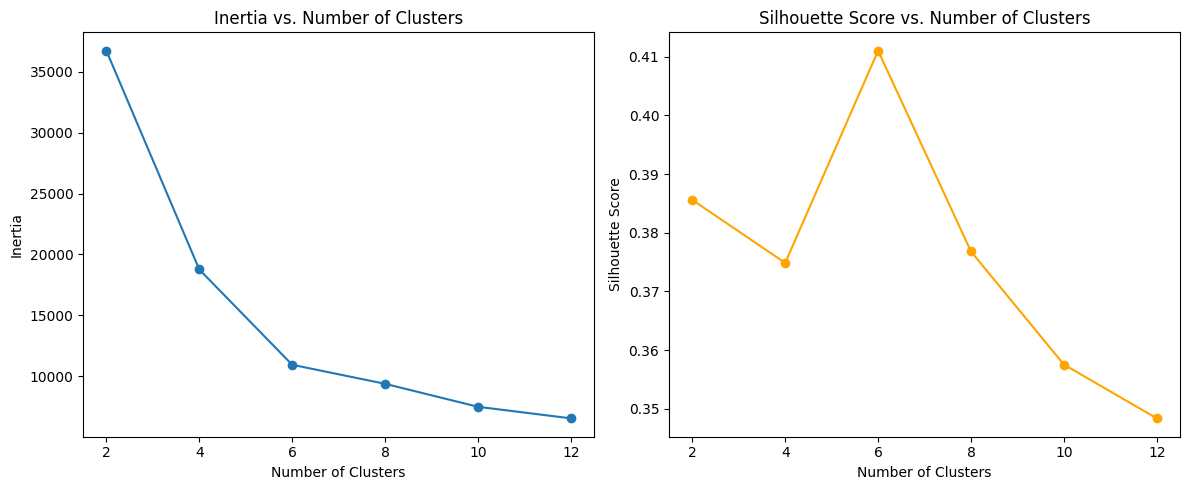

Number of clusters tested: [2, 4, 6, 8, 10, 12]
Inertia: [36705.9453125, 18771.427734375, 10961.142578125, 9399.396484375, 7515.5341796875, 6568.39306640625]
Silhouette Scores: [0.38558632, 0.37486422, 0.41101402, 0.37680855, 0.35754097, 0.34837788]


In [51]:
plt.figure(figsize=(12, 5))

# Plot Inertia
plt.subplot(1, 2, 1)
plt.plot(num_clusters_list, inertias, marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(num_clusters_list, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

print("Number of clusters tested:", num_clusters_list)
print("Inertia:", inertias)
print("Silhouette Scores:", silhouette_scores)


# 6. Choose a Number of Clusters and Compress the Image

In [54]:
chosen_n_clusters = 50

# Fit KMeans with the chosen cluster number
kmeans = KMeans(n_clusters=chosen_n_clusters, random_state=42)
kmeans.fit(pixels)

dominant_colors = kmeans.cluster_centers_

dominant_colors_255 = (dominant_colors * 255).astype(np.uint8)

labels = kmeans.labels_
print(len(labels))

compressed_pixels = dominant_colors[labels]
compressed_pixels_255 = dominant_colors_255[labels]

# Reshape to the original dimensions
compressed_image_np = compressed_pixels_255.reshape((height, width, num_channels))

# Convert NumPy array back to PIL image
compressed_image = Image.fromarray(compressed_image_np)


305920


# 7. Display the Compressed Image

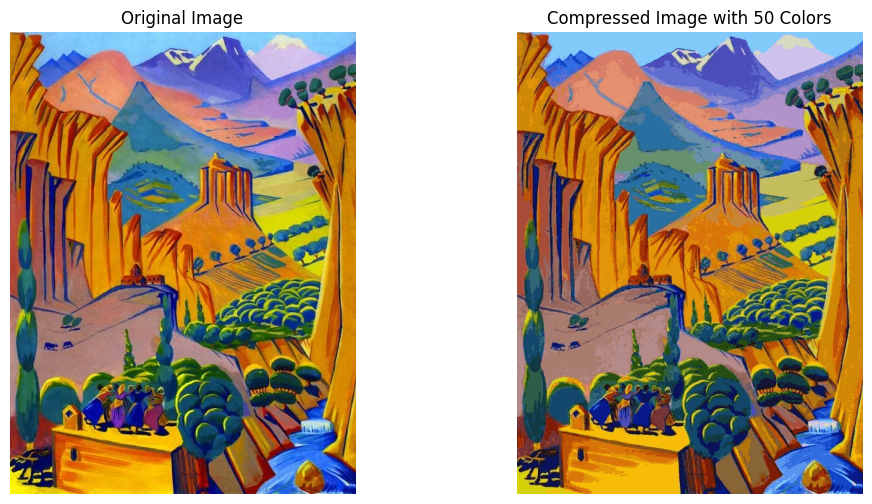

Compressed image saved to compressed_Saryan.jpg


In [55]:
# Display the original and compressed images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Compressed image
axes[1].imshow(compressed_image)
axes[1].set_title(f"Compressed Image with {chosen_n_clusters} Colors")
axes[1].axis('off')

plt.show()

# Optionally, save it
file_name = f"compressed_{input_image_path.split('.')[0]}.jpg"
compressed_image.save(file_name)
print(f"Compressed image saved to {file_name}")

In [40]:
dominant_colors_255

array([[166, 117, 104],
       [ 73,  56,  35],
       [233, 186, 120],
       [ 96,  75,  47],
       [110,  82,  85],
       [247, 221, 151],
       [218, 160, 110],
       [201, 141, 107],
       [ 37,  34,  19],
       [154, 107,  99],
       [239, 198, 125],
       [143, 105,  69],
       [ 92,  72,  83],
       [188, 133, 110],
       [223, 199, 151],
       [177, 125, 107],
       [114,  91,  64],
       [139,  98,  96],
       [ 50,  40,  21],
       [179, 137,  80],
       [245, 211, 135],
       [198, 146, 119],
       [ 96,  85, 108],
       [ 88,  68,  43],
       [161, 119,  77],
       [123, 100,  73],
       [142, 119,  96],
       [223, 172, 122],
       [ 77,  63,  75],
       [124,  90,  91],
       [ 67,  51,  29],
       [ 24,  23,  14],
       [171, 146, 117],
       [ 96,  76,  64],
       [186, 162, 129],
       [227, 184, 133],
       [209, 158, 122],
       [212, 150, 106],
       [198, 161,  89],
       [131, 109,  83],
       [ 55,  46,  60],
       [249, 227

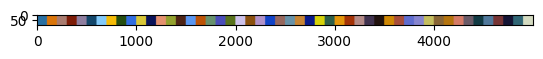

In [56]:
# Display the dominant colors
# just create tiles of the dominant colors  
dominant_colors_image = Image.new("RGB", (chosen_n_clusters * 100, 100))
for i, color in enumerate(dominant_colors_255):
    color_image = Image.new("RGB", (100, 100), color=tuple(color))
    dominant_colors_image.paste(color_image, (i * 100, 0))
    
plt.imshow(dominant_colors_image)


# 8. Compression Ratio

In [57]:
# compare file sizes of the original and compressed images
import os

original_size = os.path.getsize(input_image_path)
compressed_size = os.path.getsize(file_name)

print(f"Original image size: {original_size} bytes")
print(f"Compressed image size: {compressed_size} bytes")
print(f"Compression ratio: {original_size / compressed_size:.2f}")

Original image size: 66760 bytes
Compressed image size: 73802 bytes
Compression ratio: 0.90


# 9. Color Pallete

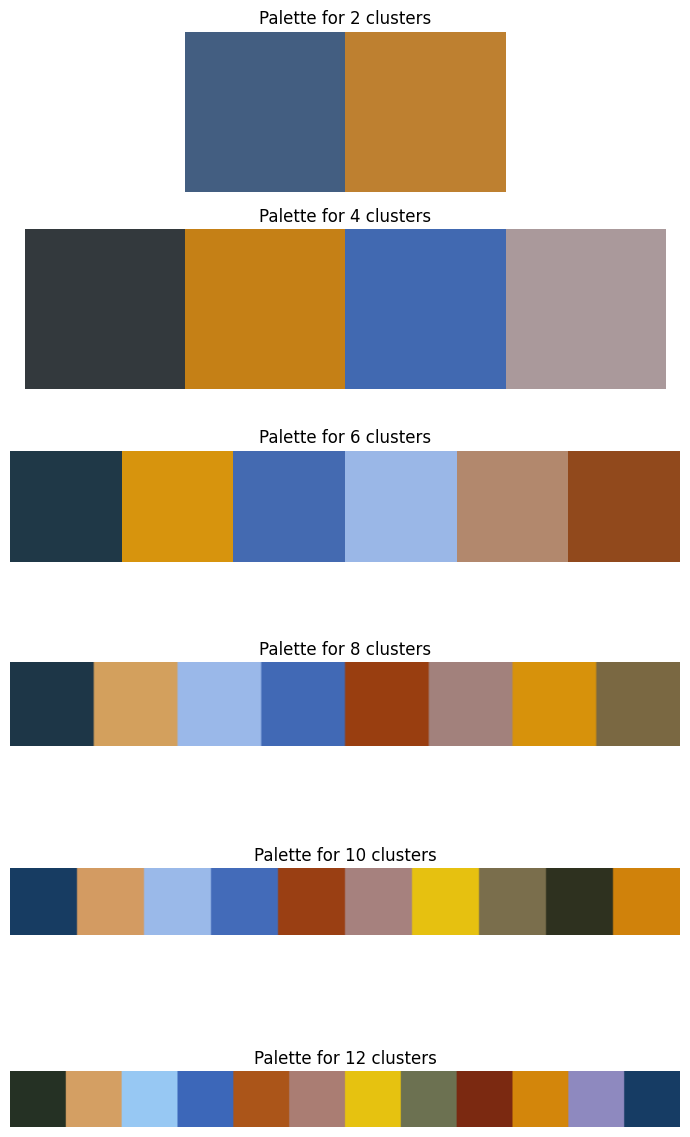

In [58]:
dominant_colors_list = centroids
cluster_counts = [2, 4, 6, 8, 10, 12]

fig, axes = plt.subplots(nrows=len(dominant_colors_list), figsize=(7, 2 * len(dominant_colors_list)))

# If there's only one palette, 'axes' won't be an iterable; ensure it's a list
if len(dominant_colors_list) == 1:
    axes = [axes]

# Loop over each set of cluster centroids and display its palette
for idx, (colors_float, k) in enumerate(zip(dominant_colors_list, cluster_counts)):
    # Convert from [0,1] float to [0,255] uint8
    colors_255 = (colors_float * 255).astype(np.uint8)

    # Create a palette image: width = (#colors * tile_size), height = tile_size
    tile_size = 30
    width = len(colors_255) * tile_size
    palette_img = Image.new("RGB", (width, tile_size))

    # Paste a 100x100 tile for each color
    for i, color in enumerate(colors_255):
        tile = Image.new("RGB", (tile_size, tile_size), color=tuple(color))
        palette_img.paste(tile, (i * tile_size, 0))

    # Display the palette in the corresponding subplot
    axes[idx].imshow(palette_img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Palette for {k} clusters")

plt.tight_layout()
plt.show()